In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Function to determine probability of switching

In [2]:
def probability_at_time(pc, n_coop_cur, n_coop_pop, n_trials_cur, n_trials_pop, pop_info): # p is probability of current partner coop; n_total is the number of trials
    a = 1
    b = 1

    pc = pc
    switch_fit_multiplier = 1

    T = 0.8 # D / C
    R = 0.6 # C / C
    P = 0.2 # D / D
    S = 0.4 # C / D
    
    population_a = a + pop_info * n_coop_pop
    population_b = b + pop_info * (n_trials_pop - n_coop_pop)
        
    current_a = population_a + n_coop_cur
    current_b = population_b + (n_trials_cur - n_coop_cur)

    samples_current = stats.beta.rvs(current_a, current_b, size=10000)
    samples_population = stats.beta.rvs(population_a, population_b, size=10000)

    staying_fitness =  (
            samples_current * (pc * R + (1 - pc) * T) +
            (1 - samples_current) * (pc * S + (1 - pc) * P)
        )

    switching_fitness =  (
            samples_population * (pc * R + (1 - pc) * T) +
            (1 - samples_population) * (pc * S + (1 - pc) * P)
        )

    payoff_difference = (switching_fitness * switch_fit_multiplier) - staying_fitness
    ps = np.mean(payoff_difference > 0) # expectation that switching is better than staying
    
    payoff = ps * (switching_fitness * switch_fit_multiplier) + (1 - ps) * staying_fitness # expected payoff
    
    return list([np.mean(payoff), ps, samples_current, samples_population, np.std(payoff)])

# Model components

In [9]:
class Population:
    def __init__(self):
        self.animals = []

    def attach_animal(self, animal):
        self.animals.append(animal)
        animal.population = self

    def summary(self):
        return [animal.summary() for animal in self.animals]

class Animal:
    def __init__(self, id, pc):
        self.id = id
        self.pc = pc
        self.ps = 0

        self.partner = None
        self.n_coop_cur = 0
        self.n_coop_pop = 0
        self.n_trials_cur = 0
        self.n_trials_pop = 0
        self.n_partners = 0
        self.n_partners_switched_from = 0
        self.n_steps = 0
        self.n_partners_overtime = []
        self.prob_switch = []
        self.prob_coop = []
        self.payoff = []
        self.payoff_sd = []
        self.time = []
        self.samples_current = []
        self.samples_population = []
        self.partner_ids = []
        self.partner_prob_coop = []

        self.population = None

    def step(self, i):
        self.n_steps += 1
        if self.partner is None:
            if np.random.uniform(0, 1) < 0.5:
                self._find_new_partner()
            else:
                payoff = 0.4
                self.payoff.append(payoff)

        if self.partner is not None:
            result = probability_at_time(self.pc, self.n_coop_cur, self.n_coop_pop, self.n_trials_cur, self.n_trials_pop, x) # probability of switching and payoff

            self.n_coop_cur += round(self.partner.pc, 0) # binarise cooperation -- cooperate or not?
            self.n_coop_pop += round(self.partner.pc, 0)
            self.n_trials_cur += 1
            self.n_trials_pop += 1

            prob = result[1] # probability of switching
            self.ps = result[1]

            self.prob_switch.append(prob) # append data to animal lists
            self.time.append(i)
            self.payoff_sd.append(result[4])
            self.n_partners_overtime.append(self.n_partners)
            self.samples_current = result[2]
            self.samples_population = result[3]
            self.prob_coop.append(self.pc) 
            self.partner_ids.append(self.partner.id)
            self.partner_prob_coop.append(self.partner.pc)

            if prob > np.random.uniform(0, 1): # if probability of switching high enough, find new partner
                self._find_new_partner()
            
            self._reckoning() # calculate payoff
            
            if self.payoff[-1] < np.random.uniform(0, 1): # if payoff is too low, adjust cooperativeness
                self.pc = self.pc + np.random.normal(0, 0.1)
                timer = 0
                while self.pc > 1 or self.pc < 0 and timer < 100:
                    self.pc = self.pc + np.random.normal(0, 0.1)
                    timer += 1
                if self.pc > 1:
                    self.pc = 1
                elif self.pc < 0:
                    self.pc = 0

    def _reckoning(self):
        payoff = 0
        if self.partner.pc > np.random.uniform(0, 1):
            if self.pc > np.random.uniform(0, 1):
                payoff = 0.6
            else:
                payoff = 0.8
        else: # if my partner defects
            if self.pc > np.random.uniform(0, 1):
                payoff = 0.4
            else:
                payoff = 0.2
        self.payoff.append(payoff)

    def _find_new_partner(self):
        candidate_partners = self.population.animals.copy()
        candidate_partners.remove(self)
        if self.partner is not None:
            self.partner.n_partners_switched_from += 1
            candidate_partners.remove(self.partner)
            self.partner.partner = None
            self.partner = None
        for animal in candidate_partners:
                if animal.partner is not None:
                    candidate_partners.remove(animal)

        if len(candidate_partners) > 0:
            self.partner = np.random.choice(candidate_partners)
            self.partner.partner = self
            self.n_partners += 1
            self.n_coop_cur = 0
            self.n_trials_cur = 0
        else:
            self.partner = None

    def summary(self):
        return {
            'id': self.id,
            'pc': self.pc,
            'partner': self.partner.id if self.partner is not None else None,
            'n_coop_cur': self.n_coop_cur,
            'n_coop_pop': self.n_coop_pop,
            'n_trials_cur': self.n_trials_cur,
            'n_trials_pop': self.n_trials_pop,
            'n_partners': self.n_partners,
            'prob_switch': self.prob_switch,
            'prob_coop': self.prob_coop,
            'partner_prob_coop': self.partner_prob_coop,
            'time': self.time,
            'payoff': self.payoff,
            'n_partners_overtime': self.n_partners_overtime,
            'partner_id': self.partner.ids,
            'payoff_sd': self.payoff_sd,
            'samples_current': self.samples_current,
            'samples_population': self.samples_population,
            'n_partners_switched_from': self.n_partners_switched_from
        }
    
 

# Model run

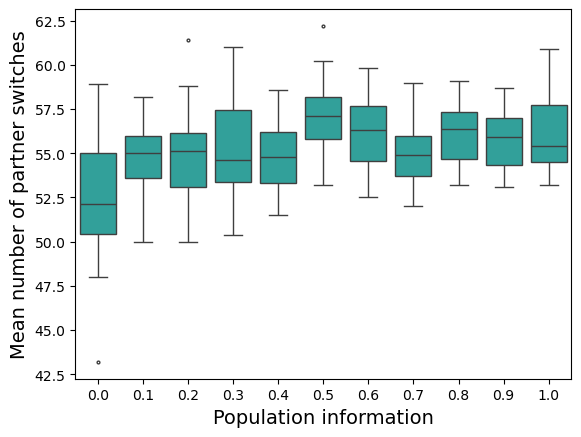

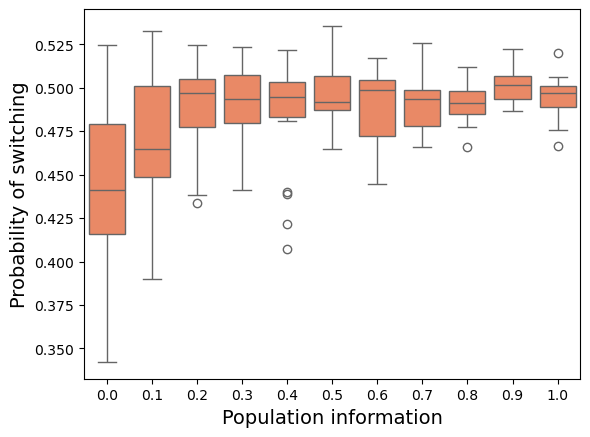

In [ ]:
all_mean_n_partners = []
all_std_n_partners = []
all_uncertainty = []
all_mean_pc = []
all_std_pc = []
all_mean_ps = []
all_pop_pc_dist = []
all_iterations = []
all_mean_payoff = []
all_std_payoff = []
all_mean_partner_pc = []
all_std_partner_pc = []
all_steps = []
all_mean_switched_from = []
all_rsquared_asstmnt = []
all_coef_asstmnt = []
all_rsquared_payoff = []
all_coef_payoff = []

pop_info = np.arange(0, 1.1, 0.01)

num_iterations = 20
num_timesteps = 1000
for x in pop_info:
    for j in np.arange(0, num_iterations):
        population_size = 10
        population = Population()

        for id in range(population_size):
            population.attach_animal(Animal(id, stats.beta.rvs(3, 3, size=1)[0])) 

        for i in range(num_timesteps):
            animal = np.random.choice(population.animals)
            animal.step(i)

        mean_n_partners = np.mean([animal.n_partners for animal in population.animals]) # calculate data means for the populations
        std_n_partners = np.std([animal.n_partners for animal in population.animals])
        mean_n_switched_from = np.mean([animal.n_partners_switched_from for animal in population.animals])
        mean_pc = np.mean([animal.pc for animal in population.animals])
        std_pc = np.std([animal.pc for animal in population.animals])
        mean_ps = np.mean([animal.ps for animal in population.animals])
        # mean_payoff = np.mean([animal.payoff[-1] for animal in population.animals])
        # std_payoff = np.std([animal.payoff[-1] for animal in population.animals])
        mean_partner_pc = np.mean([animal.partner.pc for animal in population.animals if animal.partner is not None])
        std_partner_pc = np.std([animal.partner.pc for animal in population.animals if animal.partner is not None])

        all_mean_n_partners.append(mean_n_partners) # add data to lists
        all_std_n_partners.append(std_n_partners)
        all_mean_switched_from.append(mean_n_switched_from)
        all_mean_pc.append(mean_pc)
        all_std_pc.append(std_pc)
        all_mean_ps.append(mean_ps)
        all_uncertainty.append(x)
        all_iterations.append(j)
        # all_mean_payoff.append(mean_payoff)
        # all_std_payoff.append(std_payoff)
        all_mean_partner_pc.append(mean_partner_pc)
        all_std_partner_pc.append(std_partner_pc)

df = pd.DataFrame({'iteration': all_iterations, 'all_uncertainty': all_uncertainty, 'mean_number_partners': all_mean_n_partners, 'sd_number_partners': all_std_n_partners, 'mean_pc': all_mean_pc, 'sd_pc': all_std_pc, 'mean_ps': all_mean_ps, 'mean_partner_pc': all_mean_partner_pc, 'mean_partner_sd': all_std_partner_pc, 'mean_switched_from': all_mean_switched_from})

# write to csv
game = 'SD'
# df.to_csv('data/Final/{}/data.csv'.format(game), index=False)

p = sns.boxplot(data=df, x=round(df['all_uncertainty'],1), y=df['mean_number_partners'], color="lightseagreen", fliersize=2)
# ax.fill_between(agg_df['all_uncertainty'], agg_df['lower'], agg_df['upper'], alpha=0.5, color="teal")
p.set(xlabel='Population information', ylabel='Mean number of switches')
# change the size of the axis labels font
p.set_xlabel('Population information', fontsize=14)
p.set_ylabel('Mean number of partner switches', fontsize=14)
plt.show()

p = sns.boxplot(data=df, x=round(df['all_uncertainty'], 3), y=df['mean_ps'], color="coral")
p.set(xlabel='Population information', ylabel='Probabilitty of switching')
p.set_xlabel('Population information', fontsize=14)
p.set_ylabel('Probability of switching', fontsize=14)
plt.show()